<img src = "https://github.com/singlestore-labs/spaces-notebooks/blob/e551e274bb67bb1e5081131ee1150cdba713fc43/common/images/singlestore-jupyter.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Movie Recommender Part 5</h1>
    </div>
</div>

In [11]:
!pip cache purge --quiet

In [12]:
!conda install -y --quiet -c conda-forge openjdk

Solving environment: ...working... done

# All requested packages already installed.



In [13]:
!pip install pyspark --quiet

# Create Spark Session

In [14]:
from pyspark.sql import SparkSession

# Create Spark session with all required packages
spark = (SparkSession
             .builder
             .config("spark.executor.extraJavaOptions", "-XX:ThreadStackSize = 4096")
             .appName("Spark Movie Recommender")
             .getOrCreate()
        )

spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/15 19:26:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load Data

In [15]:
import pandas as pd

In [16]:
extract_dirs = [
    "posters",
    "datasets"
]

In [17]:
movies_df = pd.read_csv(
    f"{extract_dirs[1]}/ml-1m/movies.csv"
)

users_df = pd.read_csv(
    f"{extract_dirs[1]}/ml-1m/users.csv"
)

ratings_df = pd.read_csv(
    f"{extract_dirs[1]}/ml-1m/ratings.csv"
)

In [18]:
movies = spark.createDataFrame(movies_df)
movies.show(5)

+---+--------------------+--------------------+--------------------+
| id|               title|              genres|              poster|
+---+--------------------+--------------------+--------------------+
|  1|    Toy Story (1995)|Animation|Childre...|https://m.media-a...|
|  2|      Jumanji (1995)|Adventure|Childre...|https://m.media-a...|
|  3|Grumpier Old Men ...|      Comedy|Romance|https://m.media-a...|
|  4|Waiting to Exhale...|        Comedy|Drama|https://m.media-a...|
|  5|Father of the Bri...|              Comedy|https://m.media-a...|
+---+--------------------+--------------------+--------------------+
only showing top 5 rows



In [19]:
users = spark.createDataFrame(users_df)
users.show(5)

+---+------+---+--------+--------------------+
| id|gender|age|zip_code|          occupation|
+---+------+---+--------+--------------------+
|  1|     F|  1|   48067|        K-12 student|
|  2|     M| 56|   70072|       self-employed|
|  3|     M| 25|   55117|           scientist|
|  4|     M| 45|   02460|executive/managerial|
|  5|     M| 25|   55455|              writer|
+---+------+---+--------+--------------------+
only showing top 5 rows



In [20]:
ratings = spark.createDataFrame(ratings_df)
ratings.show(5)

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|      1|    1193|     5|978300760|
|      1|     661|     3|978302109|
|      1|     914|     3|978301968|
|      1|    3408|     4|978300275|
|      1|    2355|     5|978824291|
+-------+--------+------+---------+
only showing top 5 rows



# Build Initial Model

## Create Train-Test Split

In [21]:
from pyspark.ml.recommendation import ALS

# Split the data into training and test sets
train, test = ratings.cache().randomSplit([0.7, 0.3], seed = 42)

# Set default values for best params
best_rank = 20
best_maxIter = 20
best_regParam = 0.1

## Hyperparameter Tuning

In [22]:
# from pyspark.ml.evaluation import RegressionEvaluator
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# # Hyperparameter tuning using a ParamGrid and CrossValidator
# paramGrid = (ParamGridBuilder()
#              .addGrid(als.rank, [10, 20])
#              .addGrid(als.maxIter, [10, 20])
#              .addGrid(als.regParam, [0.01, 0.1])
#              .build()
#             )

# evaluator = RegressionEvaluator(
#     metricName = "rmse",
#     labelCol = "rating",
#     predictionCol = "prediction"
# )

# crossval = CrossValidator(
#     estimator = als,
#     estimatorParamMaps = paramGrid,
#     evaluator = evaluator,
#     numFolds = 5
# )

# # Run cross-validation, and choose the best set of parameters.
# cvModel = crossval.fit(train)

# # Make predictions on the test set
# predictions = cvModel.transform(test)

# # Evaluate the model
# rmse = evaluator.evaluate(predictions)
# print(f"Root-mean-square error = {rmse}")

# # Extract the best model
# best_model = cvModel.bestModel

# # Get the best hyperparameters
# best_rank = best_model._java_obj.parent().getRank()
# best_maxIter = best_model._java_obj.parent().getMaxIter()
# best_regParam = best_model._java_obj.parent().getRegParam()

# print(f"Best rank: {best_rank}")
# print(f"Best maxIter: {best_maxIter}")
# print(f"Best regParam: {best_regParam}")

In [23]:
# Build the ALS model
als = ALS(
    rank = best_rank,
    maxIter = best_maxIter,
    regParam = best_regParam,
    userCol = "user_id",
    itemCol = "movie_id",
    ratingCol = "rating",
    coldStartStrategy = "drop",
    seed = 0
)

model = als.fit(train)

## Create Predictions

In [24]:
predictions = model.transform(test)

predictions.show(5)

+-------+--------+------+---------+----------+
|user_id|movie_id|rating|timestamp|prediction|
+-------+--------+------+---------+----------+
|    148|      11|     5|977334939| 4.0483246|
|    148|      17|     4|977334824| 3.8400905|
|    148|      89|     4|977333762| 3.3684185|
|    148|     107|     4|979577717|  3.518443|
|    148|     165|     3|977333786|  3.927862|
+-------+--------+------+---------+----------+
only showing top 5 rows



In [25]:
from pyspark.ml.evaluation import RegressionEvaluator

metrics = [
    "rmse",
    "mae",
    "mse"
]

# Dictionary to store results
results = {}

# Loop through the metrics and evaluate
for metric in metrics:
    evaluator = RegressionEvaluator(
        metricName = metric,
        labelCol = "rating",
        predictionCol = "prediction"
    )
    results[metric] = evaluator.evaluate(predictions)
    print(f"{metric.upper()} = {results[metric]}")

RMSE = 0.8621965955023309


MAE = 0.6869507168588972


MSE = 0.7433829692958099


# Visualisations

## Precision-Recall Curve

In [26]:
import numpy as np
from pyspark.sql.functions import col

# Convert ratings to binary relevance
threshold = 3.5
predictions = predictions.withColumn(
    "rating_binary",
    (col("rating") >= threshold).cast("int")
)

# Define a range of thresholds to evaluate
thresholds = np.arange(0.0, 5.0, 0.1)

# Initialise lists to store precision and recall values
precisions = []
recalls = []

# Calculate precision and recall for each threshold
for t in thresholds:
    preds = predictions.withColumn(
        "predicted_binary",
        (col("prediction") >= t).cast("int")
    )

    TP = preds.filter(
        (col("rating_binary") == 1) & (col("predicted_binary") == 1)
    ).count()
    FP = preds.filter(
        (col("rating_binary") == 0) & (col("predicted_binary") == 1)
    ).count()
    FN = preds.filter(
        (col("rating_binary") == 1) & (col("predicted_binary") == 0)
    ).count()

    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    
    precisions.append(precision)
    recalls.append(recall)

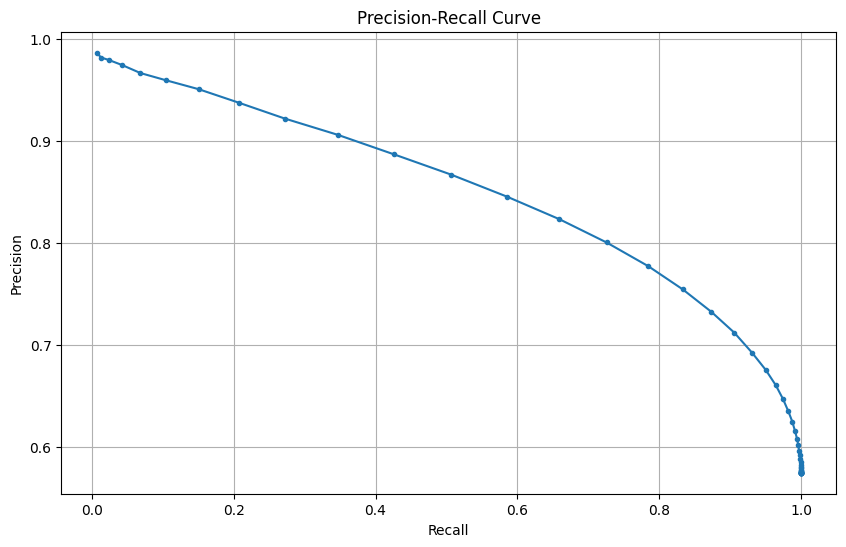

In [27]:
import matplotlib.pyplot as plt

# Plot precision-recall curve
plt.figure(figsize = (10, 6))
plt.plot(
    recalls,
    precisions,
    marker = "."
)

plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.grid(True)
plt.show()

## ROC Curve and AUC

In [28]:
# Initialise lists to store FPR and TPR values
fprs = []
tprs = []

# Calculate FPR and TPR for each threshold
for t in thresholds:
    preds = predictions.withColumn(
        "predicted_binary",
        (col("prediction") >= t).cast("int")
    )

    TP = preds.filter(
        (col("rating_binary") == 1) & (col("predicted_binary") == 1)
    ).count()
    FP = preds.filter(
        (col("rating_binary") == 0) & (col("predicted_binary") == 1)
    ).count()
    TN = preds.filter(
        (col("rating_binary") == 0) & (col("predicted_binary") == 0)
    ).count()
    FN = preds.filter(
        (col("rating_binary") == 1) & (col("predicted_binary") == 0)
    ).count()

    fpr = FP / (FP + TN) if (FP + TN) != 0 else 0.0
    tpr = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    
    fprs.append(fpr)
    tprs.append(tpr)

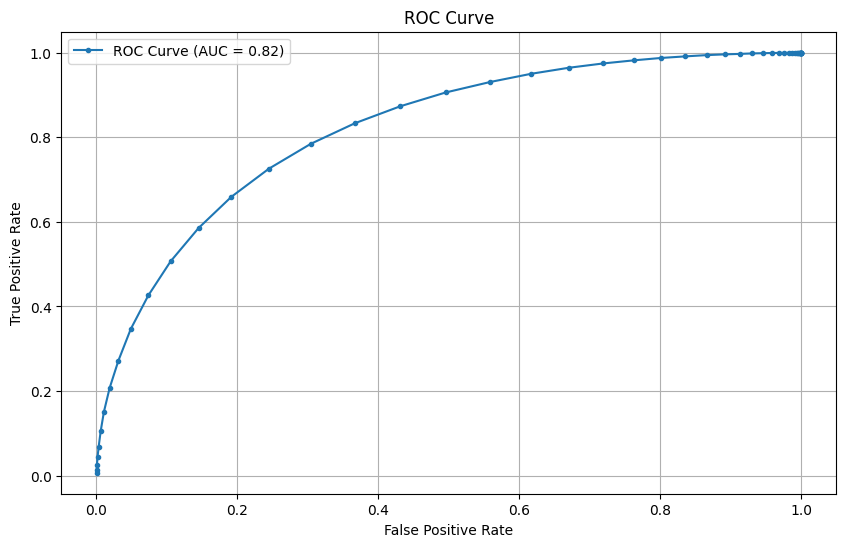

In [29]:
from sklearn.metrics import auc

# Calculate AUC
roc_auc = auc(fprs, tprs)

# Plot ROC curve
plt.figure(figsize = (10, 6))
plt.plot(
    fprs,
    tprs,
    marker = ".",
    label = f"ROC Curve (AUC = {roc_auc:.2f})"
)

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend()
plt.grid(True)
plt.show()

## Confusion Matrix

In [30]:
import seaborn as sns
from pyspark.sql.functions import when

# Convert ratings to binary relevance for the test set
threshold = 3.5
predictions = predictions.withColumn(
    "rating_binary",
    when(col("rating") >= threshold, "Positive").otherwise("Negative")
).withColumn(
    "predicted_binary",
    when(col("prediction") >= threshold, "Positive").otherwise("Negative")
)

# Calculate counts for confusion matrix
conf_matrix = predictions.groupBy("rating_binary", "predicted_binary").count()

# Collect the results
conf_matrix_results = conf_matrix.collect()

# Initialise confusion matrix
conf_matrix_dict = {
    ("Positive", "Positive"): 0,
    ("Positive", "Negative"): 0,
    ("Negative", "Positive"): 0,
    ("Negative", "Negative"): 0
}

# Fill confusion matrix dictionary
for row in conf_matrix_results:
    conf_matrix_dict[(row["rating_binary"], row["predicted_binary"])] = row["count"]

# Convert to confusion matrix
cm = [
    [conf_matrix_dict[("Positive", "Positive")], conf_matrix_dict[("Positive", "Negative")]],
    [conf_matrix_dict[("Negative", "Positive")], conf_matrix_dict[("Negative", "Negative")]]
]

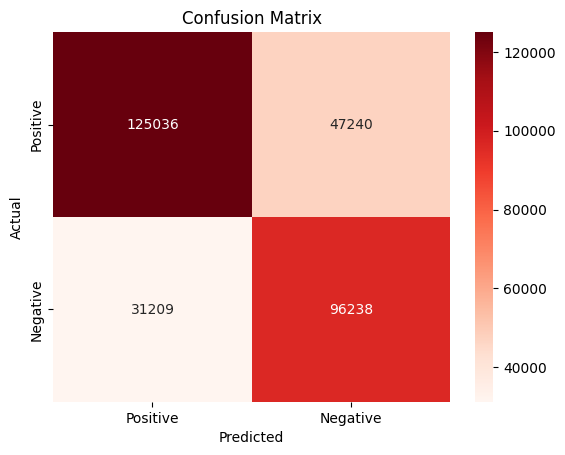

In [31]:
sns.heatmap(
    cm,
    annot = True,
    fmt = "d",
    cmap = "Reds",
    xticklabels = ["Positive", "Negative"],
    yticklabels = ["Positive", "Negative"]
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

## Coverage and Diversity

In [32]:
# User Coverage
unique_users = ratings.select("user_id").distinct().count()
users_with_recommendations = predictions.select("user_id").distinct().count()
user_coverage = users_with_recommendations / unique_users
print(f"User Coverage: {user_coverage:.2%}")

# Item Diversity
recommended_items = predictions.select("movie_id").distinct().count()
total_items = ratings.select("movie_id").distinct().count()
item_diversity = recommended_items / total_items
print(f"Item Diversity: {item_diversity:.2%}")

User Coverage: 100.00%


Item Diversity: 93.98%


## User Factors

In [33]:
user_factors = model.userFactors
user_factors.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.7283098, 0.010...|
| 20|[1.2950541, -0.21...|
| 30|[0.99966156, -0.1...|
| 40|[0.9723207, -0.11...|
| 50|[1.1545575, -0.32...|
+---+--------------------+
only showing top 5 rows



## Item Factors

In [34]:
item_factors = model.itemFactors
item_factors.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.99995583, 0.14...|
| 20|[0.7838794, 0.163...|
| 30|[0.834408, -0.018...|
| 40|[0.43188366, -0.1...|
| 50|[1.2910109, -0.26...|
+---+--------------------+
only showing top 5 rows



# Generate Recommendations

In [35]:
# Generate top 10 movie recommendations for each user
user_recs = model.recommendForAllUsers(10)
# Show recommendations for a few users
user_recs.show(5)

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|     26|[{3314, 4.204579}...|
|     27|[{923, 4.9680195}...|
|     28|[{3245, 4.3949566...|
|     31|[{1198, 4.4405303...|
|     34|[{318, 4.9368625}...|
+-------+--------------------+
only showing top 5 rows



In [36]:
# Generate top 10 user recommendations for each movie
movie_recs = model.recommendForAllItems(10)
# Show recommendations for a few movies
movie_recs.show(5)

+--------+--------------------+
|movie_id|     recommendations|
+--------+--------------------+
|      12|[{2155, 4.079452}...|
|      26|[{4086, 4.491638}...|
|      27|[{3902, 4.6084194...|
|      28|[{5072, 5.0507646...|
|      31|[{2364, 4.57245},...|
+--------+--------------------+
only showing top 5 rows



In [37]:
from pyspark.sql.functions import explode, col

user_recs_exploded = user_recs.filter(
    col("user_id") == 1).withColumn("recommendations", explode("recommendations")
)

In [38]:
user_recs_exploded.show()

+-------+-----------------+
|user_id|  recommendations|
+-------+-----------------+
|      1|  {527, 4.776223}|
|      1|  {953, 4.733473}|
|      1| {318, 4.7119274}|
|      1| {1035, 4.694879}|
|      1|{3517, 4.6652985}|
|      1|{3233, 4.6526017}|
|      1|  {602, 4.632542}|
|      1| {364, 4.5998464}|
|      1| {595, 4.5896587}|
|      1| {1097, 4.587428}|
+-------+-----------------+



In [39]:
result = user_recs_exploded.select(
    col("user_id"),
    col("recommendations.movie_id").alias("movie_id"),
    col("recommendations.rating").alias("predicted_rating")
)

result.show()

+-------+--------+----------------+
|user_id|movie_id|predicted_rating|
+-------+--------+----------------+
|      1|     527|        4.776223|
|      1|     953|        4.733473|
|      1|     318|       4.7119274|
|      1|    1035|        4.694879|
|      1|    3517|       4.6652985|
|      1|    3233|       4.6526017|
|      1|     602|        4.632542|
|      1|     364|       4.5998464|
|      1|     595|       4.5896587|
|      1|    1097|        4.587428|
+-------+--------+----------------+



In [40]:
result_with_movies = result.join(
    movies.select(
        col("id").alias("movie_id"), "title", "genres", "poster"
    ),
    on = "movie_id", how = "inner")

final_result_sorted = result_with_movies.select(
    "user_id", "movie_id", "title", "genres", "predicted_rating", "poster"
).orderBy(col("predicted_rating").desc()).limit(10)

In [41]:
final_result_sorted.show(5)

+-------+--------+--------------------+-----------+----------------+--------------------+
|user_id|movie_id|               title|     genres|predicted_rating|              poster|
+-------+--------+--------------------+-----------+----------------+--------------------+
|      1|     527|Schindler's List ...|  Drama|War|        4.776223|https://m.media-a...|
|      1|     953|It's a Wonderful ...|      Drama|        4.733473|https://m.media-a...|
|      1|     318|Shawshank Redempt...|      Drama|       4.7119274|https://m.media-a...|
|      1|    1035|Sound of Music, T...|    Musical|        4.694879|https://m.media-a...|
|      1|    3517|   Bells, The (1926)|Crime|Drama|       4.6652985|https://placehold...|
+-------+--------+--------------------+-----------+----------------+--------------------+
only showing top 5 rows



In [42]:
df = final_result_sorted.toPandas()

In [43]:
# Display movie recommendations with posters
from IPython.display import display, HTML

# Function to generate HTML img tag for each row
def display_image(url):
    return f'<img src = "{url}" width = "100">'

# Generate HTML content for table with outline and text/images for posters
html_table = []
html_table.append('<table style = "border-collapse: collapse; width: 100%; border: 1px solid #ddd;">')
html_table.append('<tr style = "text-align: left; border-bottom: 1px solid #ddd;">')
html_table.append('<th style = "padding: 10px; border-right: 1px solid #ddd;">Title</th>')
html_table.append('<th style = "padding: 10px;">Poster</th>')
html_table.append('</tr>')

# Iterate over DataFrame rows to populate table rows
for i in range(len(df)):
    html_table.append('<tr>')
    html_table.append(f'<td style = "padding: 10px; border-right: 1px solid #ddd;">{df["title"].iloc[i]}</td>')
    html_table.append(f'<td style = "padding: 10px;">{display_image(df["poster"].iloc[i])}</td>')
    html_table.append('</tr>')

html_table.append('</table>')

display(HTML(''.join(html_table)))

Title,Poster
Schindler's List (1993),
It's a Wonderful Life (1946),
"Shawshank Redemption, The (1994)",
"Sound of Music, The (1965)",
"Bells, The (1926)",
Smashing Time (1967),
"Great Day in Harlem, A (1994)",
"Lion King, The (1994)",
Beauty and the Beast (1991),
E.T. the Extra-Terrestrial (1982),


In [44]:
spark.stop()